# Feature Engineering

---

1. Import packages
2. Load data
3. Feature engineering

---

## 1. Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# shows plots in jupyter notebook
%matplotlib inline

# set plot style
sns.set(color_codes=True)

---
## 2. Load data

In [2]:
client_df = pd.read_csv('../data/client_price_data.csv')
client_df["date_activ"] = pd.to_datetime(client_df["date_activ"], format='%Y-%m-%d')
client_df["date_end"] = pd.to_datetime(client_df["date_end"], format='%Y-%m-%d')
client_df["date_modif_prod"] = pd.to_datetime(client_df["date_modif_prod"], format='%Y-%m-%d')
client_df["date_renewal"] = pd.to_datetime(client_df["date_renewal"], format='%Y-%m-%d')

In [3]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,num_years_antig,origin_up,pow_max,churn,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1,0.124787,0.100749,0.06653,40.942265,22.35201,14.90134
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0,0.149609,0.007124,0.00000,44.311375,0.00000,0.00000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0,0.170512,0.088421,0.00000,44.385450,0.00000,0.00000


---

## 3. Feature engineering

In [4]:
price_df = pd.read_csv('../data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
diff.describe()

,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
count,16096.000000,16096.000000
mean,-0.004545,0.279544
std,0.012778,1.432820
min,-0.148477,-44.266931
25%,-0.008161,0.000004
50%,-0.005610,0.162916
75%,-0.003573,0.177779
max,0.168958,40.728885


In [7]:
# merge with client data
client_df = pd.merge(client_df, diff, on='id', how='left')

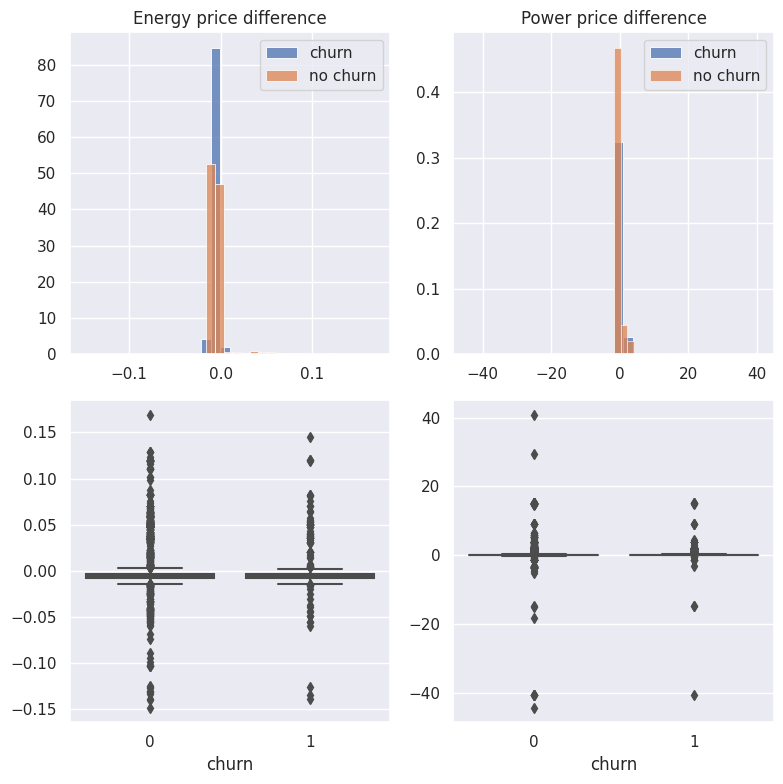

In [8]:
# plot the distribution of the difference by churn
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# energy price difference - histogram
sns.histplot(data=client_df.loc[client_df['churn'] == 0], x='offpeak_diff_dec_january_energy', stat='density', ax=axes[0, 0], bins=30, label='churn')
sns.histplot(data=client_df.loc[client_df['churn'] == 1], x='offpeak_diff_dec_january_energy', stat='density', ax=axes[0, 0], bins=30, label='no churn')
axes[0, 0].set_title('Energy price difference')
axes[0, 0].legend()
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('')

# power price difference - histogram
sns.histplot(data=client_df.loc[client_df['churn'] == 0], x='offpeak_diff_dec_january_power', stat='density', ax=axes[0, 1], bins=30, label='churn')
sns.histplot(data=client_df.loc[client_df['churn'] == 1], x='offpeak_diff_dec_january_power', stat='density', ax=axes[0, 1], bins=30, label='no churn')
axes[0, 1].legend()
axes[0, 1].set_title('Power price difference')
axes[0, 1].legend()
axes[0, 1].set_xlabel('')
axes[0, 1].set_ylabel('')

# energy price difference - boxplot
sns.boxplot(data=client_df, x='churn', y='offpeak_diff_dec_january_energy', ax=axes[1, 0])
axes[1, 0].set_ylabel('')

# power price difference - boxplot
sns.boxplot(data=client_df, x='churn', y='offpeak_diff_dec_january_power', ax=axes[1, 1])
axes[1, 1].set_ylabel('')

plt.tight_layout()
plt.show()

There few differences between the distributions of churns and non churns, which indicates that the 2 features could be useful.  
The two features we added constitute a difference, which could be interpreted as a measure of variation, so it seems reasonable to add features wich indicates a central tendency.  
We've already added the mean from the analysis phase, let's rename those features for clarity.

In [9]:
client_df.rename(columns={
    'price_off_peak_var': 'offpeak_mean_energy',
    'price_off_peak_fix': 'offpeak_mean_power',
    'price_peak_var': 'peak_mean_energy',
    'price_peak_fix': 'peak_mean_power',
    'price_mid_peak_var': 'midpeak_mean_energy',
    'price_mid_peak_fix': 'midpeak_mean_power'
}, inplace=True)

Let's regroup categorical features.

In [10]:
# origin_up
client_df['origin'] = client_df.origin_up
client_df.loc[client_df['origin'].isin(['MISSING', 'ewxeelcelemmiwuafmddpobolfuxioce', 'usapbepcfoloekilkwsdiboslwaxobdp']), 'origin'] = 'OTHER'

In [11]:
client_df['channel'] = client_df.channel_sales
client_df.loc[client_df['channel'].isin(['epumfxlbckeskwekxbiuasklxalciiuu', 'fixdbufsefwooaasfcxdxadsiekoceaa', 'sddiedcslfslkckwlfkdpoeeailfpeds']), 'channel'] = 'OTHER'

In [12]:
client_df['active_products'] = client_df.nb_prod_act
client_df.loc[client_df['active_products'] > 4, 'active_products'] = 'OTHER'

In [13]:
client_df['antiquity'] = client_df.num_years_antig
client_df.loc[client_df['antiquity'].isin([1, 2, 7, 8, 9, 10, 11, 12, 13]), 'antiquity'] = 'OTHER'

Let's drop the old features.

In [14]:
client_df.drop(columns={
    'channel_sales',
    'origin_up',
    'nb_prod_act',
    'num_years_antig'
}, inplace=True)

Let's drop the columns that are highly correlated with others.

In [15]:
client_df.drop(columns={
    'cons_12m',
    'margin_gross_pow_ele',
    'forecast_cons_year',
    'forecast_cons_12m'
}, inplace=True)

Let's drop dates columns.

In [16]:
client_df.drop(columns={
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
}, inplace=True)

In [17]:
client_df.drop(columns={
    'id'
}, inplace=True)

In [18]:
client_df.drop(columns={
    'forecast_price_energy_peak',
    'forecast_meter_rent_12m',
    'cons_gas_12m',
    'cons_last_month',
    'forecast_discount_energy'
}, inplace=True)

Let's rename the remaining columns.

In [19]:
client_df.rename(columns={
    'forecast_price_energy_off_peak': 'offpeak_price_energy_forecast',
    'forecast_price_pow_off_peak': 'offpeak_price_power_forecast'
}, inplace=True)

---

## 4. Model Building

First, let's establish a baseline.
Since the churn rate is about 10%, we might think of random guessing, that predicts churn with a probability of 10%. We might also think of a model that always predicts non churn, which would be right 90% of the time.

Let's define a metric to evaluate our models.  
When we go back to the business problem, we don't want to lose customers, in other words, when there is a company that is likely to churn, we want to be able to identify it.  Recall is the metric that measures that.
One other thing is that when we predict that a company will churn, we want to be right, because we'll be giving it a discount of 20%, which is a cost for us. Precision is the metric that measures that.

Given that, we'll use the F1 score, which is the harmonic mean of precision and recall.

### Baseline

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve

def print_scores(y_true, y_pred):
    print(f'Accuacy: {accuracy_score(y_true, y_pred):.2f}')
    print(f'Precision: {precision_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'Recall: {recall_score(y_true, y_pred, zero_division=0):.2f}')
    print(f'F1: {f1_score(y_true, y_pred, zero_division=0):.2f}')

In [21]:
# first baseline
baseline_1_guesses = np.random.choice([0, 1], size=len(client_df), p=[.9, .1])
print_scores(client_df.churn, baseline_1_guesses)

Accuacy: 0.82
Precision: 0.09
Recall: 0.10
F1: 0.10


In [22]:
# second baseline
baseline_2_guesses = np.array([0] * len(client_df))
print_scores(client_df.churn, baseline_2_guesses)

Accuacy: 0.90
Precision: 0.00
Recall: 0.00
F1: 0.00


After establishing these 2 baselines, let's try to build a model that performs better than that.

Given the business requirements, we need to work with the random forest classifier.

### Random Forest

In [123]:
from sklearn.model_selection import train_test_split

X = pd.get_dummies(client_df.drop(columns='churn'))
y = client_df.churn

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')
print_scores(y_train, y_pred_train)
print()
print('Test scores:')
print_scores(y_test, y_pred_test)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Test scores:
Accuacy: 0.91
Precision: 0.83
Recall: 0.07
F1: 0.12


We have successfully built the model that performs perfectly on the training set, but it doesn't generalize well on the test set.  
Let's see if we can get similar performance using only the features that seem to have an association with churn.

In [126]:
features = ['imp_cons', 'net_margin', 'margin_net_pow_ele', 'offpeak_mean_energy', 'offpeak_mean_power', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']

X_train = X_train[features]
X_test = X_test[features]

In [127]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')
print_scores(y_train, y_pred_train)
print()
print('Test scores:')
print_scores(y_test, y_pred_test)

Train scores:
Accuacy: 1.00
Precision: 1.00
Recall: 1.00
F1: 1.00

Test scores:
Accuacy: 0.90
Precision: 0.51
Recall: 0.07
F1: 0.13


We are getting the same performance, but with a LOT less features.  
It's time to move on to tuning the hyperparameters.

### Hyperparameters tuning

In [145]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        class_weight={0: 1, 1: 5},
        max_depth=15,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')
print_scores(y_train, y_pred_train)
print()
print('Test scores:')
print_scores(y_test, y_pred_test)

Train scores:
Accuacy: 0.97
Precision: 1.00
Recall: 0.65
F1: 0.79

Test scores:
Accuacy: 0.91
Precision: 0.65
Recall: 0.08
F1: 0.15


In [147]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'rf__class_weight': [{0: 1, 1: 5}, {0: 1, 1: 7}, {0: 1, 1: 10}],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(class_weight={0: 1,
                                                                             1: 5},
                                                               max_depth=15,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__class_weight': [{0: 1, 1: 5}, {0: 1, 1: 7},
                                              {0: 1, 1: 10}],
                         'rf__max_depth': [10, 15, 20],
                         'rf__min_samples_split': [2, 5, 10]},
             scoring='f1')

In [148]:
grid_search.best_params_

{'rf__class_weight': {0: 1, 1: 10},
 'rf__max_depth': 10,
 'rf__min_samples_split': 10}

In [149]:
pipeline = grid_search.best_estimator_

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')
print_scores(y_train, y_pred_train)
print()
print('Test scores:')
print_scores(y_test, y_pred_test)

Train scores:
Accuacy: 0.87
Precision: 0.40
Recall: 0.70
F1: 0.51

Test scores:
Accuacy: 0.80
Precision: 0.21
Recall: 0.37
F1: 0.27


We notice that we are still overfitting, let's try see if there are more hyperparameters to tune.

In [151]:
pipeline.set_params(rf__ccp_alpha=0.001)

pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

print('Train scores:')
print_scores(y_train, y_pred_train)
print()
print('Test scores:')
print_scores(y_test, y_pred_test)

Train scores:
Accuacy: 0.74
Precision: 0.22
Recall: 0.66
F1: 0.33

Test scores:
Accuacy: 0.70
Precision: 0.16
Recall: 0.51
F1: 0.25


Right now, we can try to find a better balance between precision and recall.  
The precision-recall curve will allow us to find the best probability threshold for classification.

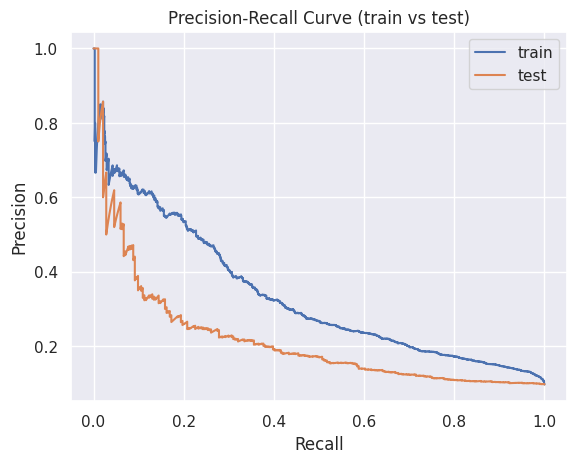

In [154]:
y_scores_train = pipeline.predict_proba(X_train)[:, 1]
y_scores_test = pipeline.predict_proba(X_test)[:, 1]

precision_train, recall_train, thresholds_train = precision_recall_curve(y_train, y_scores_train)
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_scores_test)

plt.plot(recall_train, precision_train, label='train')
plt.plot(recall_test, precision_test, label='test')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (train vs test)')
plt.legend()
plt.show()

In [174]:
y_pred_test = (pipeline.predict_proba(X_test)[:, 1] > 0.57).astype(int)
print_scores(y_test, y_pred_test)

Accuacy: 0.82
Precision: 0.22
Recall: 0.33
F1: 0.26


In terms of precision, recall and f1 score, we are beating the baseline.
Random guessing, which is the best possible baseline we can think of, would give us a precision of 10%, as well as recall.  
We were able to reach 33% recall and 22% precision, leading to a recall of 26%.

---

## Conclusion

Overall, these metrics aren't very high, this could be due to the fact that maybe price isn't a main driver of churn, and that we need to look at other factors and do more experiments.